# Linear Model

### Prepare venv

In [49]:
dir = "../../dataset/variance_big_256/"
labels = ["canter", "trot", "walk"]

rng = 42

batch_size = 8
epochs = 10

#### imports

In [50]:
import numpy as np
import os

from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import TensorDataset, DataLoader

#### load variances

In [51]:
files = sorted(os.listdir(dir))

X_list, y_list = [], []

for label in labels:
    for file in sorted(os.listdir(dir + label)):
        var = np.load(dir + label + "/" + file).astype(np.float32)
        X_list.append(var)
        y_list.append(labels.index(label))

X = np.stack(X_list, axis=0)       # shape: (N, 256, 256)
y = np.array(y_list)               # shape: (N,)

#### train/test split

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rng)

## Tensors

In [53]:
import torch.nn.functional as F

### Train

In [54]:
X_tensor = torch.tensor(X_train[:, None, :, :], dtype=torch.float32)
y_tensor = torch.tensor(y_train, dtype=torch.long)
y_onehot = F.one_hot(y_tensor, num_classes=3).float()

dataset = TensorDataset(X_tensor, y_onehot)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

### Test

In [55]:
X_test_tensor = torch.tensor(X_test[:, None, :, :], dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)
y_test_onehot = F.one_hot(y_test_tensor, num_classes=3).float()

test_dataset = TensorDataset(X_test_tensor, y_test_onehot)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [56]:
for X, y in test_loader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([8, 1, 256, 256])
Shape of y: torch.Size([8, 3]) torch.float32


## Model

In [57]:
import torch.nn as nn

class LinearClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(256 * 256, 3)
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.fc(x)

## Training

In [58]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LinearClassifier().to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(
    model.parameters(),
    lr=0.01,
    momentum=0.9)

In [59]:
def train(dataLoader, model, criterion, optimizer):
    model.train()
    
    running_loss = 0
    for batch, (X, y) in enumerate (dataLoader):
        X, y = X.to(device), y.to(device)
        
        pred = model(X)
        loss = criterion(pred, y)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        running_loss += loss.item()
        
    running_loss /= len(dataLoader)
    return running_loss

In [60]:
def eval(testLoader, model, criterion):
    model.eval()
    
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for X, y in testLoader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += criterion(pred, y).item()
            
            true_labels = y.argmax(dim=1)
            correct += (pred.argmax(dim=1) == true_labels).sum().item()
            
    test_loss /= len(testLoader)
    correct /= len(testLoader.dataset)
    return test_loss, correct

### Loop

In [61]:
losses = []

for epoch in range(epochs):
    running_loss = train(loader, model, criterion, optimizer)
    test_loss, correct = eval(test_loader, model, criterion)
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss:.4f}, Test loss: {test_loss:.4f}")
    losses.append([running_loss/len(dataset), test_loss/len(test_dataset)])
    
    print(f"Accuracy: {(100*correct):>0.1f}%")

Epoch 1/10, Loss: 404164.7219, Test loss: 173165.0996
Accuracy: 57.3%
Epoch 2/10, Loss: 337895.5634, Test loss: 494160.5683
Accuracy: 42.3%
Epoch 3/10, Loss: 300550.2645, Test loss: 213484.3727
Accuracy: 63.2%
Epoch 4/10, Loss: 152863.7486, Test loss: 155893.4173
Accuracy: 60.5%
Epoch 5/10, Loss: 110832.9709, Test loss: 335363.3063
Accuracy: 55.8%
Epoch 6/10, Loss: 169666.0608, Test loss: 384984.0186
Accuracy: 45.4%
Epoch 7/10, Loss: 197758.3713, Test loss: 114833.4360
Accuracy: 76.9%
Epoch 8/10, Loss: 74842.8253, Test loss: 282691.3125
Accuracy: 54.0%
Epoch 9/10, Loss: 91576.6290, Test loss: 354277.8261
Accuracy: 73.2%
Epoch 10/10, Loss: 78518.9320, Test loss: 143430.4515
Accuracy: 71.2%


## Evaluation

In [62]:
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

all_preds = []
all_labels = []
correct = 0
total = 0
loss_total = 0.0
criterion = torch.nn.BCEWithLogitsLoss()

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        predicted_labels = preds.argmax(dim=1)
        
        all_preds.extend(predicted_labels.cpu().numpy())
        all_labels.extend(yb.cpu().numpy())
        
        # Compute loss
        loss = criterion(preds, yb)
        loss_total += loss.item() * xb.size(0)  # sum over batch
        
        # Compute accuracy
        true_labels = yb.argmax(dim=1)
        correct += (predicted_labels == true_labels).sum().item()
        total += yb.size(0)

avg_loss = loss_total / total
accuracy = correct / total

print(f"Test Loss: {avg_loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


Test Loss: 145483.6482
Test Accuracy: 0.7117


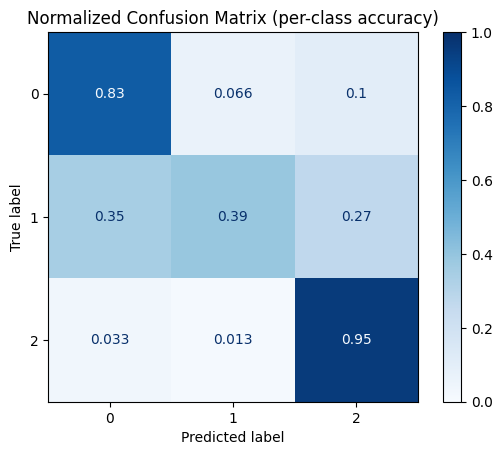

In [63]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Suppose all_labels and all_preds are defined
all_labels_indices = np.array([np.argmax(label) for label in all_labels])
cm = confusion_matrix(all_labels_indices, all_preds)

# Normalize per true class
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized,
                              display_labels=np.unique(all_labels_indices))
ax = plt.gca()
disp.plot(cmap=plt.cm.Blues, ax=ax)

# Stabilize color scale
ax.images[0].set_clim(0, 1)  # force color range 0-1

plt.title("Normalized Confusion Matrix (per-class accuracy)")
plt.show()


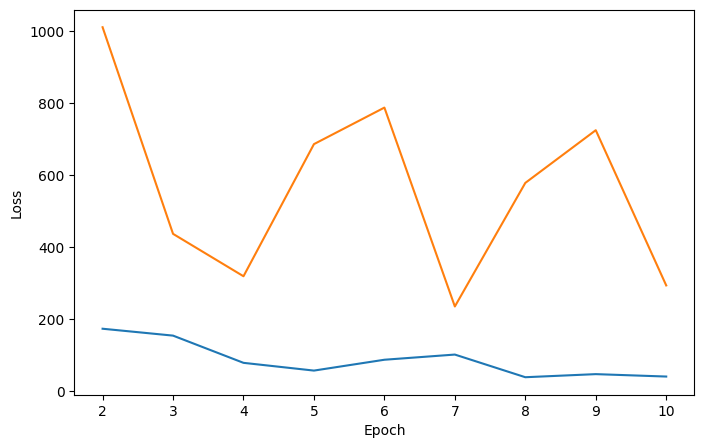

In [64]:
import matplotlib.pyplot as plt

skip = 1

losses_array = np.array(losses)  # shape -> (num_epochs, 2)

# Split columns
train_loss = losses_array[:, 0]
test_loss = losses_array[:, 1]

epochs = range(skip+1, len(train_loss)+1)

fig, ax = plt.subplots(figsize=(8,5))

# Plot loss on left y-axis
ax.plot(epochs, train_loss[skip:], label='Train Loss')
ax.plot(epochs, test_loss[skip:], label='Test Loss')
text = ax.set_xlabel('Epoch')
text = ax.set_ylabel('Loss')




# Save

In [ ]:
torch.save(model.state_dict(), 'model_temp.pth')